## 0.1 Imports

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import umap.umap_ as umap
import re

from matplotlib import pyplot as plt
from datetime import datetime

from matplotlib import cm

from sklearn import metrics as m
from sklearn import cluster as c
from sklearn import preprocessing as pp
from sklearn import decomposition as dd
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn import mixture as mx
from scipy.cluster import hierarchy as hc
from sklearn import ensemble as en

from plotly import express as px

## 0.3 Load dataset

In [8]:
# load data
df_raw = pd.read_csv(r"C:\Users\diego\OneDrive\Área de Trabalho\projects\insiders_clustering\data\Ecommerce.csv", encoding='unicode_escape')

# drop extra column
df_raw = df_raw.drop(columns=['Unnamed: 8'], axis=1)



# 1.0 DATA DESCRIPTION

In [9]:
df1 = df_raw.copy()

In [10]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.1 Rename columns

In [11]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2 Data dimensions

In [12]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 541909
Number of columns: 8


## 1.3 Data types

In [13]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [14]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

In [15]:
# spliting NA
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [16]:
# create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)

# merge original with reference dataframe
df1 = pd.merge(df1, df_backup, how='left', on='invoice_no')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'])

In [17]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6 Change dtypes

In [18]:
# invoice data
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')

# customer id
df1['customer_id'] = df1['customer_id'].astype(np.int64)

## 1.7 Descriptive statistics

In [19]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical attributes

In [20]:
num_attributes.agg(["mean","median","std","min","max","skew","kurtosis"]).T


,mean,median,std,min,max,skew,kurtosis
quantity,9.552250,3.00,218.081158,-80995.00,80995.0,-0.264076,119769.160031
unit_price,4.611114,2.08,96.759853,-11062.06,38970.0,186.506972,59005.719097
customer_id,16688.840453,16249.00,2911.411352,12346.00,22709.0,0.487449,-0.804287


### 1.7.2 Categorical attributes

### Invoice No

In [21]:
# df1['invoice_no'].astype(np.int64) - problem: invoice contains numbers and words

# identification
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))),:]
df_letter_invoices.head()

print('Total number of invoices with letters: {}'.format(len(df_letter_invoices)))
print('Total number of negatives quantities: {}'.format(len(df_letter_invoices[df_letter_invoices['quantity'] < 0])))

Total number of invoices with letters: 9291
Total number of negatives quantities: 9288


### Stock Code

In [22]:
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

### Description

In [23]:
df1['description'].head()

0     WHITE HANGING HEART T-LIGHT HOLDER
1                    WHITE METAL LANTERN
2         CREAM CUPID HEARTS COAT HANGER
3    KNITTED UNION FLAG HOT WATER BOTTLE
4         RED WOOLLY HOTTIE WHITE HEART.
Name: description, dtype: object

Description will be deleted from data since it does not give any perceptive feature to the problem

### Country

In [24]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [25]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# 2.0 VARIABLES FILTERING

In [26]:
df2 = df1.copy()

In [27]:
# ==== Numerical Attributes ====
# unit price > 0
df2= df2.loc[df2['unit_price'] >= 0.04, :]

# ==== Categorical Attributes ====
# stock code != ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']
df2 = df2.loc[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# description
df2 = df2.drop(columns='description', axis=1)

# map
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# bad users
df2 = df2[~df2['customer_id'].isin([16446])]

# quantity - Negative numbers will be assumed as product returns
df2_returns = df2.loc[df2['quantity'] <= 0, :]
df2_purchase = df2.loc[df2['quantity'] > 0, :]


# 3.0 FEATURE ENGINEERING

In [28]:
df3 = df2.copy()

## 3.1 Feature creation

In [29]:
# data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 
                  'quantity', 'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

### 3.1.1 Gross Revenue

In [30]:
# Gross Revenue: quantity * price
df2_purchase['gross_revenue'] = df2_purchase.apply(lambda x: x['quantity'] * x['unit_price'], axis = 1)

# Monetary
df_monetary = df2_purchase[[ 'customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, how='left', on='customer_id')
df_ref.isna().sum()


C:\Users\diego\AppData\Local\Temp\ipykernel_9672\59910178.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchase['gross_revenue'] = df2_purchase.apply(lambda x: x['quantity'] * x['unit_price'], axis = 1)


customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2 Recency

In [31]:
# Recency - Last day purchase

max_invoice_date = df2_purchase['invoice_date'].max()

df_recency = df2_purchase.loc[:, ['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = df_recency['invoice_date'].apply(lambda x:  max_invoice_date - x).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
df_ref.isna().sum()


customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.4 Quantity of Items Purchased

In [32]:
# total quantity of procucts purchased by customer
df_prod = df2_purchase.loc[:, ['customer_id','quantity']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_prod, on='customer_id', how='left')
df_ref = df_ref.rename(columns={'quantity': 'total_quantity'})

df_ref.isna().sum()


customer_id        0
gross_revenue     91
recency_days      91
total_quantity    91
dtype: int64

In [33]:
df_ref1 = df_ref.copy()

### 3.1.7 Frequency

In [34]:
df_aux = ( df2_purchase[['customer_id', 'invoice_date', 'invoice_no']].drop_duplicates()
                                                             .groupby('customer_id')
                                                             .agg(max_=('invoice_date', 'max'), 
                                                                  min_=('invoice_date', 'min'),
                                                                  days_=('invoice_date', lambda x: ((x.max() - x.min()).days) + 1),
                                                                  buy_=('invoice_no', 'count')).reset_index())

# frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_']/x['days_'] if x['days_'] != 0 else 0, axis=1)

df_aux.head()

# merge
df_ref1 = pd.merge(df_ref1, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')

In [35]:
df_ref1.isna().sum()

customer_id        0
gross_revenue     91
recency_days      91
total_quantity    91
frequency         91
dtype: int64

### 3.1.8 Returns

In [36]:
df_returns = df2_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qty_returns'})
df_returns['qty_returns'] = df_returns['qty_returns']*(-1)

df_ref1 = pd.merge(df_ref1, df_returns, on='customer_id', how='left')
df_ref1.loc[df_ref1['qty_returns'].isna(), 'qty_returns'] = 0
df_ref1.isna().sum()

customer_id        0
gross_revenue     91
recency_days      91
total_quantity    91
frequency         91
qty_returns        0
dtype: int64

### 3.1.9 Basket Size

In [37]:
df_aux = (df2_purchase.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                        .agg(n_purchase=('invoice_no', 'nunique'),
                                                             n_products=('quantity', 'sum'))
                                                        .reset_index()  )

# calculation
df_aux['avg_basket_size'] = df_aux['n_products']/df_aux['n_purchase']

# merge
df_ref1 = pd.merge(df_ref1, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id')

df_ref1.isna().sum()

customer_id         0
gross_revenue      91
recency_days       91
total_quantity     91
frequency          91
qty_returns         0
avg_basket_size    91
dtype: int64

In [38]:
df_ref1.head()

,customer_id,gross_revenue,recency_days,total_quantity,frequency,qty_returns,avg_basket_size
0,17850,5391.21,372.0,1733.0,17.000000,40.0,50.970588
1,13047,3232.59,56.0,1390.0,0.028302,35.0,154.444444
2,12583,6705.38,2.0,5028.0,0.040323,50.0,335.200000
3,13748,948.25,95.0,439.0,0.017921,0.0,87.800000
4,15100,876.00,333.0,80.0,0.073171,22.0,26.666667


# 4.0 EXPLORATORY DATA ANALYSIS

In [39]:
df4 = df_ref1.copy()
df4 = df4.dropna()
df4.isna().sum()

customer_id        0
gross_revenue      0
recency_days       0
total_quantity     0
frequency          0
qty_returns        0
avg_basket_size    0
dtype: int64

## 4.3 Embedding study

In [42]:
# df43 = df4.drop(columns=['customer_id'], axis=1).copy()

cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'total_quantity', 'qty_returns', 'frequency', 'avg_basket_size']
df43 = df4[cols_selected].copy() 

In [43]:
mm = pp.MinMaxScaler()

df43['gross_revenue']      = mm.fit_transform(df43[['gross_revenue']])
df43['recency_days']       = mm.fit_transform(df43[['recency_days']])
df43['total_quantity']     = mm.fit_transform(df43[['total_quantity']])
df43['frequency']          = mm.fit_transform(df43[['frequency']])
df43['qty_returns']        = mm.fit_transform(df43[['qty_returns']])
df43['avg_basket_size']        = mm.fit_transform(df43[['avg_basket_size']])



In [44]:
X = df43.copy()

### 4.3.4 Tree-Based Embedding

Tree-Based Embedding is a tool used to organize cluster with a target variable that, in this case, is the **Gross Revenue**.

It is a great method to create embedding for clustering when may explain the cluster's proximity but not the points similarity between them

In [48]:
# training dataset

X = df43.drop(columns=['customer_id', 'gross_revenue'], axis=1)
y = df43['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor(n_estimators=100, random_state=42)

# model training
rf_model.fit(X, y)

# Leaf
df_leaf = pd.DataFrame(rf_model.apply(X))

# dataframe Leaf

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

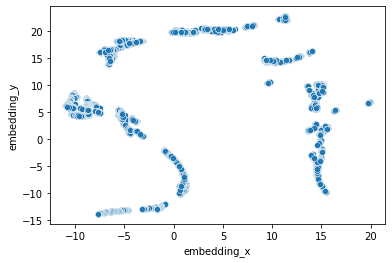

In [49]:
# Reducer dimensionality
reducer = umap.UMAP(n_neighbors=80, random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

sns.scatterplot(x='embedding_x', y='embedding_y', data=df_tree)


c:\Users\diego\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\diego\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

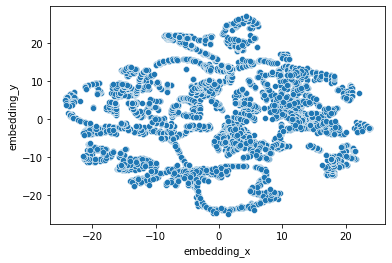

In [47]:
# reducer = TSNE(n_components=3, random_state=42, n_jobs=-1)
# embedding = reducer.fit_transform(X)

# # embedding
# df_tree['embedding_x'] = embedding[:, 0]
# df_tree['embedding_y'] = embedding[:, 1]

# #plot UMAP
# sns.scatterplot(x='embedding_x', y='embedding_y', data= df_tree)

#  7.0 HYPERPARAMETER FINE-TUNING

In [50]:
X = df_tree.copy()

#  8.0 MODEL TRAINING

## 8.1 Final Model

In [51]:
# model definition
k = 8
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 8.2 Cluster Validation

In [52]:
## WSS (Within-cluster Sum of Square)
print('wss value: {}'.format(kmeans.inertia_))

## SS (Silhouette Score)
print('SS value: {}'. format(m.silhouette_score(X, labels, metric='euclidean')))


wss value: 53027.29296875
SS value: 0.6195657849311829


## 9.2 Cluster profile

In [53]:
df92 = df4[cols_selected].copy()
df92['cluster'] = labels
df92.head()

# change the types
df92['recency_days'] = df92['recency_days'].astype(np.int64)
df92['total_quantity'] = df92['total_quantity'].astype(np.int64)
df92['qty_returns'] = df92['qty_returns'].astype(np.int64)

df92['last_training_timestamp'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

df92.head()

,customer_id,gross_revenue,recency_days,total_quantity,qty_returns,frequency,avg_basket_size,cluster,last_training_timestamp
0,17850,5391.21,372,1733,40,17.000000,50.970588,7,2022-10-27 13:21:25
1,13047,3232.59,56,1390,35,0.028302,154.444444,7,2022-10-27 13:21:25
2,12583,6705.38,2,5028,50,0.040323,335.200000,5,2022-10-27 13:21:25
3,13748,948.25,95,439,0,0.017921,87.800000,3,2022-10-27 13:21:25
4,15100,876.00,333,80,22,0.073171,26.666667,2,2022-10-27 13:21:25


In [54]:
# number of customers
df_cluster = df92[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_cluster'] = (df_cluster['customer_id']/df_cluster['customer_id'].sum())*100

# Avg Gross revenue
df_avg_gross_revenue = df92[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency days
df_recency_days = df92[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_recency_days, how='inner', on='cluster')

# Avg quantity
df_qty = df92[['total_quantity', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_qty, how='inner', on='cluster')

# frequency
df_frequency = df92[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_frequency, how='inner', on='cluster')

# qty_returns
df_returns = df92[['qty_returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_returns, how='inner', on='cluster')

# avg_basket_size
df_basket = df92[['avg_basket_size', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_basket, how='inner', on='cluster')

df_cluster.sort_values('gross_revenue', ascending=False)

,cluster,customer_id,perc_cluster,gross_revenue,recency_days,total_quantity,frequency,qty_returns,avg_basket_size
5,5,557,9.780509,10305.230018,46.082585,5984.175943,0.219261,263.545781,899.915090
7,7,445,7.813872,2663.473416,60.294382,1480.469663,0.254381,23.548315,439.180921
1,1,751,13.187006,1622.407164,57.976032,880.486019,0.167003,12.845539,292.825188
6,6,495,8.691835,1223.615253,130.066667,491.882828,0.766842,3.892929,394.412401
3,3,702,12.326602,852.284245,85.475783,399.709402,0.249398,6.585470,181.237444
0,0,634,11.132572,503.485331,121.506309,243.362776,0.560229,3.856467,172.165523
2,2,1233,21.650571,304.541792,161.281427,117.021898,0.800100,1.424980,99.721864
4,4,878,15.417032,70.921367,193.145786,18.800683,0.979196,0.455581,18.074005


# 10.0 DEPLOY TO PRODUCTION

In [60]:
df92.dtypes

customer_id                  int64
gross_revenue              float64
recency_days                 int64
total_quantity               int64
frequency                  float64
qty_returns                  int64
cluster                      int32
last_training_timestamp     object
dtype: object

## 10.1 Insert into SQLITE

In [63]:
import sqlite3
from sqlalchemy import create_engine

In [64]:
# create table
query_create_table_insiders = """
    CREATE TABLE insiders (
        customer_id     INTEGER,
        gross_revenue   REAL,
        recency_days    INTEGER,
        total_quantity  INTEGER,
        frequency       REAL,
        qty_returns     INTEGER,
        cluster         INTEGER
        ) """

conn = sqlite3.connect('insiders_db.sqlite')
conn.execute(query_create_table_insiders)
conn.commit()
conn.close()

# insert data
conn = create_engine('sqlite:///insiders_db.sqlite')
df92.to_sql('insiders', con=conn, if_exists='append', index=False)

# select data

OperationalError: table insiders already exists

In [ ]:
# consulting database
query = """
    SELECT * FROM insiders
    """

df = pd.read_sql_query(query, conn)

In [ ]:
df.head()

,customer_id,gross_revenue,recency_days,total_quantity,frequency,qty_returns,cluster
0,17850,5391.21,372,1733,17.000000,40,5
1,13047,3232.59,56,1390,0.028302,35,1
2,12583,6705.38,2,5028,0.040323,50,5
3,13748,948.25,95,439,0.017921,0,0
4,15100,876.00,333,80,0.073171,22,2
